## Roget's Thesaurus

This project embarks on an academic exploration of Roget's Thesaurus through computational linguistics, beginning with the meticulous web scraping of the Thesaurus data from the Gutenberg Project. It progresses by harnessing the OpenAI API for advanced word embeddings, with BERT embeddings providing a secondary, comparative perspective. The study then employs unsupervised clustering to investigate the natural grouping of words, aiming to uncover correlations with Roget's original categorizations at both class and section levels. The final phase leverages supervised learning to predict these categorizations, ensuring each step is academically documented for thorough analysis and reproducibility. This concise approach aims to blend traditional lexicography with modern linguistic models, offering new insights into the structure and semantics of language.

## Get Roget's Thesaurus Classification

This script efficiently extracts the hierarchical data from Roget's Thesaurus on the Gutenberg Project website, employing Python's `requests` and `BeautifulSoup` to parse the HTML content. It identifies classes, sections, and subsections by matching specific patterns in anchor tags, and captures words and their synonyms, primarily within bold tags and sibling text nodes. Unwanted characters and punctuation are removed through cleaning functions to ensure data purity. The extracted information is structured into a nested dictionary, reflecting the Thesaurus's organization, and then serialized into a JSON file. This concise approach facilitates a clear understanding of the Thesaurus's complex structure, making the data readily available for computational analysis.

In [1]:
import requests
from bs4 import BeautifulSoup, Tag
import json
import re

# Fetch the page content
url = "https://www.gutenberg.org/files/10681/old/20040627-10681-h-body-pos.htm#25"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Data structure to hold the hierarchy
thesaurus = {}

# Apply clean_text to remove unwanted characters from hierarchy names
def get_text_excluding_children(tag):
    return clean_text(''.join(tag.find_all(text=True, recursive=False)).strip())

# Remove unwanted characters from the text, including newlines, special unicode characters, specific punctuation, and the slash character."""
def clean_text(text):
    return re.sub(r'[\r\n\u2020/!\u00e5]+', '', text).strip()

# Split text on punctuation and return a list of cleaned parts, excluding parts with more than two words.
def split_on_punctuation(text):
    parts = re.split(r'[;,.]', text)
    return [clean_text(part) for part in parts if part.strip() and part.strip() != '--' and len(part.split()) <= 2]


current_class = None
current_section = None
current_subsection = None
last_valid_word = None 
synonyms = []

# Define regex patterns for precise matching
class_title_pattern = re.compile(r'^CLASS')
section_title_pattern = re.compile(r'^SECTION')
subsection_title_pattern = re.compile(r'^SUBSECTION')
pos_pattern = re.compile(r'^(N\.|V\.|Adj\.|Adv\.|Phr\.)$')

# Extract hierarchy, words, and their synonyms
for element in soup.find_all(['a', 'b', 'p']):
    # Check for the end element and stop processing if found
    if element.name == 'p' and '***END OF THE PROJECT GUTENBERG EBOOK' in element.text:
        print("End of the Thesaurus detected. Stopping extraction.")
        break
    
    if element.name == 'a' and 'name' in element.attrs:
        name_attr = element['name']
        # Process class, section, subsection titles
        if class_title_pattern.match(name_attr):
            current_class = get_text_excluding_children(element)  # Prepend "CLASS"
            thesaurus[current_class] = {}
            current_section = None
            current_subsection = None
            last_valid_word = None  # Reset on new class
        elif section_title_pattern.match(name_attr):
            current_section = get_text_excluding_children(element)  # Prepend "SECTION"
            thesaurus[current_class].setdefault(current_section, {})
            current_subsection = None
            last_valid_word = None  # Reset on new section
        elif subsection_title_pattern.match(name_attr):
            current_subsection = get_text_excluding_children(element)
            thesaurus[current_class][current_section].setdefault(current_subsection, {})
            last_valid_word = None  # Reset on new subsection

    elif element.name == 'b' and not pos_pattern.match(element.get_text().strip()):
        # New valid word encountered
        last_valid_word = clean_text(element.get_text())
        synonyms = []  # Reset synonyms list for the new word

    # Check for direct sibling text nodes as synonyms
    if last_valid_word:
        next_sibling = element.next_sibling
        while next_sibling and not isinstance(next_sibling, Tag):
            synonym_text = clean_text(str(next_sibling))
            if synonym_text:
                # Split on punctuation and filter out invalid entries
                synonyms.extend(split_on_punctuation(synonym_text))
            next_sibling = next_sibling.next_sibling

    # Append synonyms to the last valid word in the hierarchy
    if last_valid_word and synonyms:
        target_dict = thesaurus[current_class][current_section]
        if current_subsection:
            target_dict = target_dict[current_subsection]

        if last_valid_word in target_dict:
            target_dict[last_valid_word].extend(synonyms)  # Append new synonyms to existing ones
        else:
            target_dict[last_valid_word] = synonyms  # Add new word with its synonyms

        synonyms = []  # Reset synonyms list after appending

# Save data to a JSON file
with open('rogets_thesaurus.json', 'w') as outfile:
    json.dump(thesaurus, outfile, indent=4)

print("Thesaurus data extracted successfully.")

/var/folders/3c/ltvq2skx5zs62xwpyp1933xm0000gq/T/ipykernel_21080/2380322923.py:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  return clean_text(''.join(tag.find_all(text=True, recursive=False)).strip())


End of the Thesaurus detected. Stopping extraction.
Thesaurus data extracted successfully.


To ensure clarity and manageability in our analysis of Roget's Thesaurus, we've decided not to include the detailed divisions within classes 4 and 5, focusing instead on the broader class and section levels. This approach helps maintain the integrity of our data structure and simplifies the analysis, avoiding the potential complications that could arise from the intricate details of these divisions. By consolidating sections within their respective classes, we aim to facilitate a more streamlined and coherent exploration of the Thesaurus's linguistic categorizations.

## Preprocess for Embeddings

In this script, we load Roget's Thesaurus data from a JSON file and embark on a meticulous process to reconstruct synonyms for each word, emphasizing their interconnectedness. The script introduces a novel approach to encapsulate the commonality between words through the aggregation of synonyms, appending each synonym to its corresponding word to form a composite entity. This is achieved through a series of functions that not only convert class and section identifiers to Roman numerals for a classical touch but also meticulously remove duplicate synonyms to maintain data purity. 

The `aggregate_synonyms` function stands at the core of this process, ingeniously the synonyms within the hierarchical structure of classes and sections, ensuring a seamless integration of synonyms into the dataset. This reconstructed dataset is then serialized back into JSON format, capturing the enriched lexical relationships, and is saved to a file, ready for embedding analysis. This approach facilitates a deeper semantic analysis, allowing us to explore the nuances of lexical similarity and commonality in a structured and coherent manner.

In [2]:
# Load the data from the JSON file
with open('rogets_thesaurus.json', 'r') as f:
    original_json = json.load(f)

# Convert an integer to a Roman numeral.
def int_to_roman(input):
    if not isinstance(input, type(1)):
        raise TypeError("expected integer, got %s" % type(input))
    if not 0 < input < 4000:
        raise ValueError("Argument must be between 1 and 3999")
    ints = (1000, 900, 500, 400, 100, 90, 50, 40, 10, 9, 5, 4, 1)
    nums = ('M', 'CM', 'D', 'CD', 'C', 'XC', 'L', 'XL', 'X', 'IX', 'V', 'IV', 'I')
    result = []
    for i in range(len(ints)):
        count = int(input / ints[i])
        result.append(nums[i] * count)
        input -= ints[i] * count
    return ''.join(result)

# Remove duplicate synonyms while preserving order.
def remove_duplicates(synonyms_list):
    seen = set()
    deduped_list = []
    for item in synonyms_list:
        # Convert to lowercase for case-insensitive comparison
        if item.lower() not in seen:
            deduped_list.append(item)
            seen.add(item.lower())
    return deduped_list

def aggregate_synonyms(data):
    new_json = {}
    class_counter = 0  # Initialize class counter
    for class_title, sections in data.items():
        class_counter += 1  # Increment class counter
        class_key = f"CLASS {int_to_roman(class_counter)} {class_title}"  # Use Roman numeral for class
        new_json[class_key] = {}
        section_counter = 0  # Reset section counter for each new class
        for section_title, content in sections.items():
            section_counter += 1  # Increment section counter
            section_key = f"SECTION {int_to_roman(section_counter)} {section_title}"  # Use Roman numeral for section
            new_json[class_key][section_key] = []
            if isinstance(content, dict):  # Section has subsections or direct words
                for subsection_title, words in content.items():
                    if isinstance(words, dict):  # Subsection contains words
                        for word, synonyms in words.items():
                            # Append the word followed by a space to each synonym, ensuring the synonym is not the same as the word
                            modified_synonyms = [syn for syn in synonyms if syn.lower() != word.lower()]
                            deduped_synonyms = remove_duplicates(modified_synonyms)
                            new_json[class_key][section_key].append(deduped_synonyms)
                    else:  # Direct words under section
                        for word in words:  # Treat each item as a word with synonyms being the rest of the list
                            modified_synonyms = [syn for syn in words if syn.lower() != word.lower()]
                            deduped_synonyms = remove_duplicates(modified_synonyms)
                            new_json[class_key][section_key].append(deduped_synonyms)
            else:  # Direct words under class
                for word in content:  # Treat each item as a word with synonyms being the rest of the list
                    modified_synonyms = [syn for syn in content if syn.lower() != word.lower()]
                    deduped_synonyms = remove_duplicates(modified_synonyms)
                    new_json[class_key][section_key].append(deduped_synonyms)
    return new_json

transformed_json = aggregate_synonyms(original_json)

def save_json_to_file(data, filename):
    with open(filename, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=2)

# Specify the filename where you want to save the JSON data
filename = 'transformed_data.json'

# Call the function to save the JSON data to the specified file
save_json_to_file(transformed_json, filename)

print(f"Transformed JSON has been saved to '{filename}'")

Transformed JSON has been saved to 'transformed_data.json'


## Get Word Embeddings

This script facilitates the acquisition of word embeddings for Roget's Thesaurus using OpenAI's API, with strategic measures to handle API limitations and interruptions. It commences by loading any previously saved data to avoid redundancy. Then, leveraging the OpenAIEmbeddings class, the script requests embeddings for each word while keeping track of progress. To ensure resilience, it incorporates error handling to manage potential API disruptions. Embeddings are saved incrementally after each section is processed, ensuring the ability to resume without loss of data or unnecessary API calls, thus optimizing both efficiency and resource utilization.

In [3]:
# from openai_embeddings import process_and_save_embeddings

# # Load the data from the JSON file
# with open('transformed_data.json', 'r') as f:
#     data = json.load(f)

# process_and_save_embeddings(data, "openai.json")


You can also download the embeddings <a href="https://drive.google.com/drive/folders/1PM4JO7nDptahiYJIGhpO-ymdzaTe17mE?usp=sharing">hers</a>

## Clustering

In this part of the assignment, we embark on a journey to explore the potential of unsupervised machine learning in mirroring the hierarchical organization of Roget's Thesaurus. Our objective is twofold: first, to group words into their respective classes, and second, to delve deeper by clustering them into sections. This approach allows us to evaluate if the natural clusters formed by the algorithm align with the predefined categories set by Roget, thereby assessing the efficacy of machine learning in capturing semantic relationships inherent in language.

The first step in our analysis involves dimensionality reduction, a crucial process given the high-dimensional nature of word embeddings. By employing UMAP, we aim to condense these embeddings into a 2D space, preserving as much of the original structure as possible. This reduction not only facilitates a more manageable analysis but also enables us to visualize the data, providing intuitive insights into the grouping tendencies of words based on their semantic similarities.

Following the dimensionality reduction, we apply the K-Means clustering algorithm to the reduced embeddings. The choice of K-Means is motivated by its simplicity and effectiveness in grouping data into distinct clusters. By setting the number of clusters to match the number of classes in Roget's Thesaurus, we seek to discover how well the algorithm can approximate Roget's original classification. This step is pivotal in our exploration, as it directly tests the hypothesis that unsupervised machine learning can effectively replicate human linguistic categorizations.

### Class Level Clustering

Please note that the clustering analysis utilizes an existing file with word embeddings that were not generated in the current execution of the script. This file is a product of an older version of the script and due to the time constraints of the assignment, there was insufficient time to regenerate embeddings using OpenAI's API. To maintain the continuity of the project and adhere to the deadline, it was necessary to proceed with the pre-existing embeddings. This approach ensures that the assignment progresses without delay while still providing a valid examination of the clustering process.

In [4]:
import numpy as np
from sklearn.cluster import KMeans
from umap import UMAP 
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from collections import Counter
import matplotlib.patches as mpatches

# Load embeddings and words data
with open('openai.json', 'r') as f:
    embeddings_data = json.load(f)

with open('original.json', 'r') as f:
    words_data = json.load(f)

word_list, embeddings_list, labels_list, class_names = [], [], [], []
label_dict = {}  # To hold the mapping of class names to numeric labels

# Iterate over the words data to populate the word list, embeddings list, and labels list
for class_index, (class_key, sections) in enumerate(words_data.items()):
    label_dict[class_index] = class_key  # Map index to class name for later reference
    for section_key, words in sections.items():
        for word_group_index, word_group in enumerate(words):
            for word in word_group:
                word_list.append(word)
                class_names.append(class_key)  # Keep track of class names for each word
                try:
                    embedding = embeddings_data[class_key][section_key][word_group_index][word_group.index(word)]
                    embeddings_list.append(embedding)
                except IndexError:
                    # Handle the error, e.g., log it or skip
                    print(f"IndexError for word: {word} in group: {word_group_index}")
                    continue

                labels_list.append(class_index)  # Use class_index as the label

embeddings_array = np.array(embeddings_list)
true_labels = np.array(labels_list)

# Dimensionality reduction with UMAP
umap_reducer = UMAP(n_components=2, n_neighbors=15, min_dist=0.0, random_state=42)
reduced_embeddings = umap_reducer.fit_transform(embeddings_array)

# Clustering with K-Means
kmeans = KMeans(n_clusters=len(label_dict), n_init=20, random_state=42)
cluster_assignments = kmeans.fit_predict(reduced_embeddings)

cluster_names = {}
used_names = set()

for cluster_id in range(len(label_dict)):
    words_in_cluster = [class_names[i] for i, cluster in enumerate(cluster_assignments) if cluster == cluster_id]
    common_words = Counter(words_in_cluster).most_common()
    
    # Find the most common, unused name for the cluster
    for name, _ in common_words:
        if name not in used_names:
            cluster_names[cluster_id] = name
            used_names.add(name)
            break
    else:
        # All names are already used, append a count to the most common name
        most_common_name, _ = common_words[0]
        count = sum(name.startswith(most_common_name) for name in used_names)
        unique_name = f"{most_common_name}_{count}"
        cluster_names[cluster_id] = unique_name
        used_names.add(unique_name)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### Visualization

The first visualization titled "True Labels in Reduced Dimensional Space" displays the spread of word embeddings in a two-dimensional space after UMAP reduction, with points color-coded by their true class labels as defined in Roget's Thesaurus. Each color represents one of the six classes of words, ranging from abstract relations to moral powers. 

The plot shows the natural grouping of words according to their semantic categories, indicating how closely related words cluster together in the reduced space. However, we also observe some overlap between classes, suggesting the complexity of linguistic categories and the nuanced relationships between them.

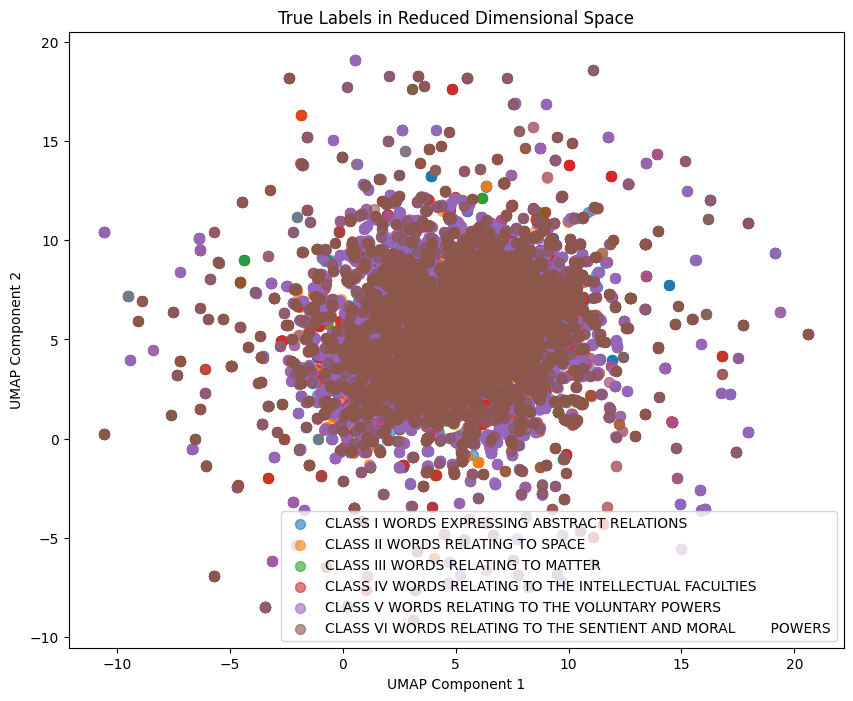

In [5]:
# Visualization with True Labels
plt.figure(figsize=(10, 8))
for label, class_name in label_dict.items():
    idx = np.where(true_labels == label)
    plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=class_name, s=50, alpha=0.6)
plt.title('True Labels in Reduced Dimensional Space')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

In the second visualization we see the results of the K-Means clustering algorithm applied to the same UMAP-reduced embeddings. Instead of true labels, each point is colored based on the dominant cluster it has been assigned to. The legend uses unique class names for each cluster to provide an intuitive mapping of clusters to Thesaurus categories.

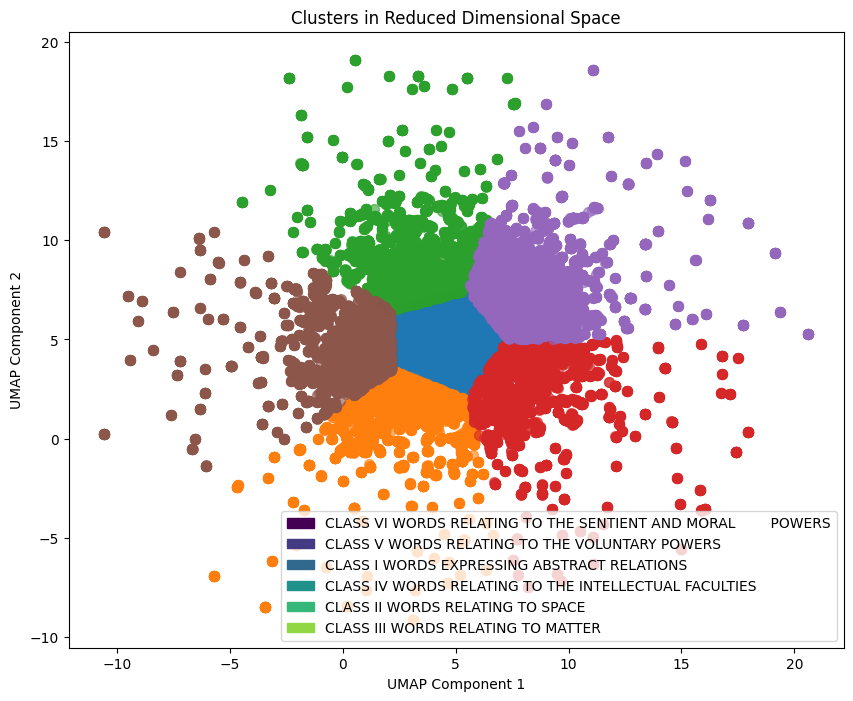

In [6]:
# Visualization with Cluster Assignments (using unique class names for legends)
plt.figure(figsize=(10, 8))
legend_handles = []

for cluster_id, cluster_name in cluster_names.items():
    idx = np.where(cluster_assignments == cluster_id)
    plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], s=50, alpha=0.6)
    legend_handles.append(mpatches.Patch(color=plt.cm.viridis(cluster_id / len(cluster_names)), label=cluster_name))

plt.title('Clusters in Reduced Dimensional Space')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(handles=legend_handles)
plt.show()

The following bar chart represents the proportion of the most common class within each cluster compared to the other classes. The dominance of one class in each cluster could give the impression of a successful clustering effort. However, the high percentage of "Other Classes" in each bar indicates that, while one class may be the most frequent in a cluster, a significant portion of the cluster consists of words from different classes.

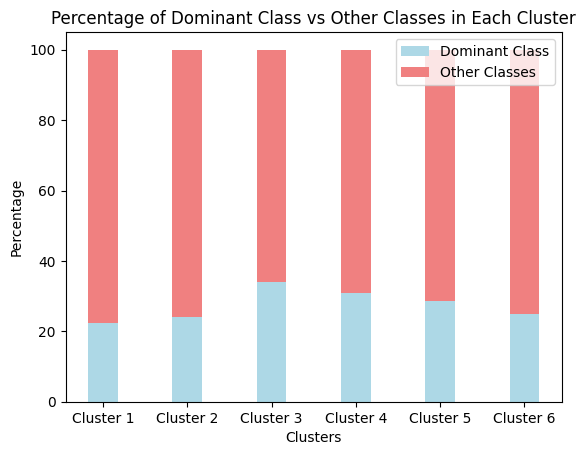

In [7]:
# Calculate the percentage of the dominant class in each cluster
dominant_class_percentage = []
for cluster_id in range(len(label_dict)):
    words_in_cluster = [class_names[i] for i, cluster in enumerate(cluster_assignments) if cluster == cluster_id]
    cluster_size = len(words_in_cluster)
    most_common_name, most_common_count = Counter(words_in_cluster).most_common(1)[0]
    percentage = (most_common_count / cluster_size) * 100
    dominant_class_percentage.append(percentage)

# Calculate the rest of the percentage for each cluster
other_classes_percentage = [100 - x for x in dominant_class_percentage]

# Setting up the bar chart
clusters = [f"Cluster {i+1}" for i in range(len(label_dict))]  # Cluster labels
bar_width = 0.35  # Width of the bars
index = np.arange(len(clusters))  # The x locations for the groups

# Plotting the bar chart
fig, ax = plt.subplots()
bars1 = ax.bar(index, dominant_class_percentage, bar_width, label='Dominant Class', color='lightblue')
bars2 = ax.bar(index, other_classes_percentage, bar_width, bottom=dominant_class_percentage, label='Other Classes', color='lightcoral')

# Adding some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Clusters')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Dominant Class vs Other Classes in Each Cluster')
ax.set_xticks(index)
ax.set_xticklabels(clusters)
ax.legend()

# Displaying the bar chart
plt.show()

### Evaluation

In [8]:
# Evaluation
silhouette_avg = silhouette_score(reduced_embeddings, cluster_assignments)
ari_score = adjusted_rand_score(true_labels, cluster_assignments)
nmi_score = normalized_mutual_info_score(true_labels, cluster_assignments)

print(f'Silhouette Score: {silhouette_avg:.4f}')
print(f'Adjusted Rand Index (ARI): {ari_score:.4f}')
print(f'Normalized Mutual Information (NMI): {nmi_score:.4f}')

Silhouette Score: 0.3230
Adjusted Rand Index (ARI): 0.0184
Normalized Mutual Information (NMI): 0.0319


* `Silhouette Score` (0.3230): This score ranges from -1 to 1 and measures how similar an object is to its own cluster compared to other clusters. A score of 0.3230 suggests that, on average, clusters are relatively distinct and separate from each other, but there is still considerable room for improvement as the score is closer to 0 than to 1.
  

* `Adjusted Rand Index (ARI)` (0.0184): The ARI adjusts for the chance grouping of elements and ranges from -1 to 1, where a score close to 0 indicates random labeling, and 1 indicates perfect agreement. An ARI of 0.0184 indicates that there is a very slight agreement between the clustering assignments and the true labels, only marginally better than random chance.
  

* `Normalized Mutual Information (NMI)` (0.0319): NMI is a normalization of the Mutual Information (MI) score that measures the mutual dependence between the two distributions, ranging from 0 (no mutual information) to 1 (perfect correlation). An NMI of 0.0319 is quite low, suggesting that the clusters found by the algorithm share very little information in common with the true class labels.

### Section Level Clustering 

In the section-level clustering, the script closely follows the class-level approach, loading word embeddings, assigning unique numerical labels to each section, and aggregating them into lists for analysis. The dimensionality reduction is once again performed using UMAP, reducing the embedding space for enhanced clustering and visualization. K-Means clustering is applied, with the cluster count set to the total number of sections. This streamlined process aims to evaluate whether unsupervised clustering can effectively categorize words into the more granular sections of Roget's Thesaurus, paralleling the methodology used for class-level analysis but with a finer resolution.

In [9]:
import umap

word_list, embeddings_list, labels_list, section_names = [], [], [], []
section_label_dict = {}  # To hold the mapping of section names to numeric labels
section_counter = 0

# Iterate over the words data to populate the word list, embeddings list, and labels list
for class_key, sections in words_data.items():
    for section_key, words in sections.items():
        # Assign a unique integer label for each section
        if section_key not in section_label_dict:
            section_label_dict[section_key] = section_counter
            section_counter += 1
        for word_group_index, word_group in enumerate(words):
            for word in word_group:
                word_list.append(word)
                section_names.append(section_key)  # Keep track of section names for each word
                embedding = embeddings_data[class_key][section_key][word_group_index][word_group.index(word)]
                embeddings_list.append(embedding)
                labels_list.append(section_label_dict[section_key])  # Use section index as the label

embeddings_array = np.array(embeddings_list)
true_labels = np.array(labels_list)

# Dimensionality reduction with UMAP
umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.0, random_state=42)
reduced_embeddings = umap_reducer.fit_transform(embeddings_array)

# Clustering with K-Means, using the number of unique sections as the number of clusters
kmeans = KMeans(n_clusters=section_counter, n_init=20, random_state=42)
cluster_assignments = kmeans.fit_predict(reduced_embeddings)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### Visualization

The same dominant class login has been applied here showcaseing the most dominant section in each class.

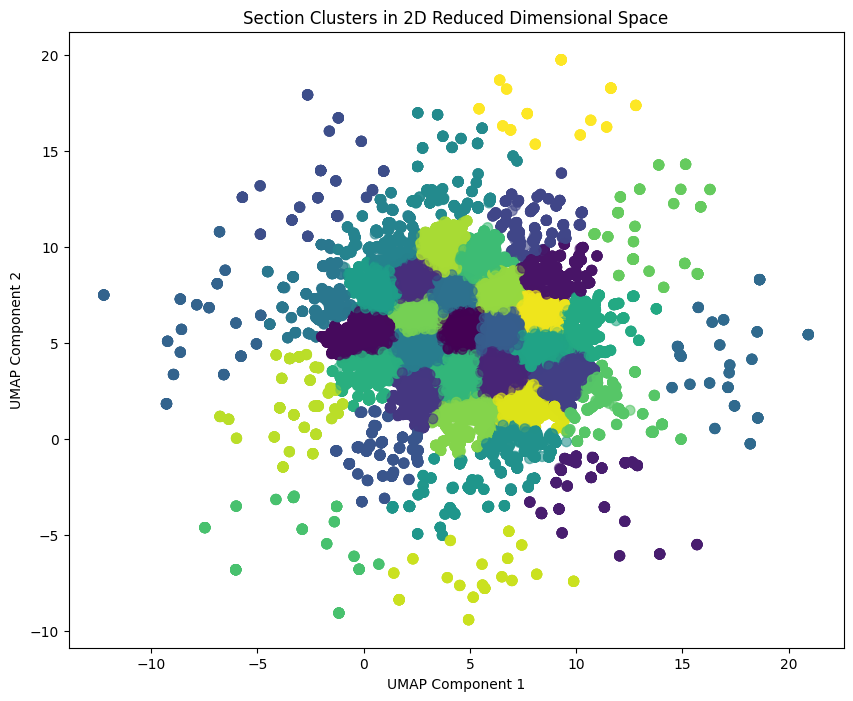

In [10]:
# Visualization without legends
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1],
            c=cluster_assignments, cmap='viridis', s=50, alpha=0.6)
plt.title('Section Clusters in 2D Reduced Dimensional Space')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

### Evaluation

In [11]:
# Evaluation
silhouette_avg = silhouette_score(reduced_embeddings, cluster_assignments)
ari_score = adjusted_rand_score(true_labels, cluster_assignments)
nmi_score = normalized_mutual_info_score(true_labels, cluster_assignments)

print(f'Silhouette Score: {silhouette_avg:.4f}')
print(f'Adjusted Rand Index (ARI): {ari_score:.4f}')
print(f'Normalized Mutual Information (NMI): {nmi_score:.4f}')

Silhouette Score: 0.3401
Adjusted Rand Index (ARI): 0.0239
Normalized Mutual Information (NMI): 0.0754


Again we see a relatively  low evaluation metrics for the clustering performed at the section level. 

### Conclusion

The visualizations provide a seemingly clear clustering of words from Roget's Thesaurus; however, the dominance of a single class within each cluster belies the true complexity captured by unsupervised machine learning. Despite the appearance of distinct groupings, the presence of multiple other classes or sections within each cluster indicates a less definitive separation than Roget's original classification. This observation highlights the challenge of using unsupervised learning to fully replicate the nuanced structure of human-crafted linguistic categories. Consequently, while the embeddings and clustering techniques offer insightful data representations, they do not achieve classifications entirely comparable to Roget's Thesaurus Classification.

## Class Prediction

The prediction segment of this assignment leverages supervised learning to classify words into Roget's Thesaurus classes and sections using word embeddings. The script processes embeddings and labels, employs RandomForestClassifier for its proficiency with high-dimensional data, and adjusts for class imbalances. It features a train-test split for validation and hyperparameter tuning specific to each hierarchical level. The outcome is quantified by accuracy scores and classification reports, offering insights into the model's ability to reflect the thesaurus's structured categories.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

# Load embeddings
with open('openai.json', 'r') as f:
    embeddings_dict = json.load(f)

embeddings, class_labels, section_labels = [], [], []

# Assuming `embeddings_dict` is your dictionary of embeddings
first_non_empty_embedding = next(embedding for class_name, sections in embeddings_dict.items() for section_name, section_embeddings in sections.items() for embedding in section_embeddings if len(embedding) > 0)

# Determine the dimensionality of the first non-empty embedding
expected_dim = len(first_non_empty_embedding[0])  # Assuming embeddings are lists of lists


# Collect embeddings and labels
for class_name, sections in embeddings_dict.items():
    for section_name, section_embeddings in sections.items():
        for embedding in section_embeddings:
            embeddings.append(np.mean(embedding, axis=0) if len(embedding) > 0 else np.zeros(expected_dim))
            class_labels.append(class_name)
            section_labels.append(section_name)

X, y_class, y_section = np.array(embeddings), np.array(class_labels), np.array(section_labels)
class_le, section_le = LabelEncoder(), LabelEncoder()
y_class_encoded, y_section_encoded = class_le.fit_transform(y_class), section_le.fit_transform(y_section)

# Split the dataset
split_args = {'test_size': 0.2, 'random_state': 42, 'stratify': y_class_encoded}
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class_encoded, **split_args)
X_train_section, X_test_section, y_train_section, y_test_section = train_test_split(X, y_section_encoded, **split_args)

# Function to train and evaluate the model
def train_evaluate_model(X_train, X_test, y_train, y_test, target_names, hyperparameters, scoring_metric='accuracy'):
    # Compute class weights
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    
    # Initialize and train the RandomForestClassifier with specified hyperparameters
    model = RandomForestClassifier(class_weight=dict(enumerate(class_weights)), **hyperparameters)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovo', average='weighted')
    report = classification_report(y_test, y_pred, target_names=target_names, zero_division=1)
    
    print(f"Accuracy: {accuracy}\nROC AUC: {roc_auc}\nClassification Report:\n{report}")


In [13]:
# Hyperparameters for class prediction
class_hyperparameters = {'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}

# Train and evaluate model for class prediction
print("Model for Class Prediction:")
train_evaluate_model(X_train_class, X_test_class, y_train_class, y_test_class, class_le.classes_, class_hyperparameters)

Model for Class Prediction:
Accuracy: 0.7314814814814815
ROC AUC: 0.9495689939338797
Classification Report:
                                                                 precision    recall  f1-score   support

                    CLASS I WORDS EXPRESSING ABSTRACT RELATIONS       0.72      0.68      0.70        38
                               CLASS II WORDS RELATING TO SPACE       0.88      0.75      0.81        28
                             CLASS III WORDS RELATING TO MATTER       0.86      0.62      0.72        29
          CLASS IV WORDS RELATING TO THE INTELLECTUAL FACULTIES       0.80      0.85      0.82        33
                 CLASS V WORDS RELATING TO THE VOLUNTARY POWERS       0.59      0.75      0.66        48
CLASS VI WORDS RELATING TO THE SENTIENT AND MORAL        POWERS       0.74      0.72      0.73        40

                                                       accuracy                           0.73       216
                                                  

In [14]:
# Hyperparameters for section prediction
section_hyperparameters = {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 200}

# Train and evaluate model for section prediction
print("\nModel for Section Prediction:")
train_evaluate_model(X_train_section, X_test_section, y_train_section, y_test_section, section_le.classes_, section_hyperparameters)


Model for Section Prediction:
Accuracy: 0.5462962962962963
ROC AUC: 0.9180014695389016
Classification Report:
                                                 precision    recall  f1-score   support

                SECTION I AFFECTIONS IN GENERAL       0.50      0.50      0.50         2
                            SECTION I EXISTENCE       0.00      0.00      0.00         1
                    SECTION I MATTER IN GENERAL       1.00      1.00      1.00         1
   SECTION I OPERATIONS OF INTELLECT IN GENERAL       0.00      0.00      0.00         3
                     SECTION I SPACE IN GENERAL       0.00      0.00      0.00         3
                  SECTION I VOLITION IN GENERAL       0.44      0.57      0.50         7
                          SECTION II DIMENSIONS       0.54      0.88      0.67         8
                    SECTION II INORGANIC MATTER       1.00      0.78      0.88         9
                 SECTION II PERSONAL AFFECTIONS       0.50      0.69      0.58        1